In [ ]:
# https://medium.com/@sacbis9/itsm-open-active-incidents-closing-prediction-incident-management-bdf1684d84dc

In [2]:
# basic libs
import re
from string import punctuation

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

# sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# NLP
import nltk
import spacy
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# sentence-transformers
from sentence_transformers import SentenceTransformer

# local exception handler (keep if you have this module)
# from src.exception_handler import handle_exception

# load models / resources
# NOTE: make sure the spacy model 'en_core_web_sm' is installed in the environment.
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])  # faster if parser+ner unused
en = spacy.load("en_core_web_sm")  # if you need full pipeline elsewhere

# sentence-transformer embedder (device can be "cpu" or "cuda")
embedder = SentenceTransformer('all-MiniLM-L6-v2', device="cpu")


In [3]:
# NLTK resources (run once)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
# optionally:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Akash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Akash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
data = pd.read_csv("movie.csv")
# normalize column names
data.columns = data.columns.str.lower().str.replace(" ", "_")

# ✅ Drop duplicates
print("Data before dropping duplicates:", data.shape)
data = data.drop_duplicates(keep="first")
print("Data after dropping duplicates:", data.shape)

# ✅ Reset index
data = data.reset_index(drop=True)


Data before dropping duplicates: (40000, 2)
Data after dropping duplicates: (39723, 2)


In [5]:
import re
import emoji
from bs4 import BeautifulSoup


def clean_html_data_in_string(input_string: str) -> str:
    """
    Cleans HTML tags from the input string.

    Args:
        input_string (str): The string containing HTML data.

    Returns:
        str: The string with HTML content removed and only text retained.
    """
    soup = BeautifulSoup(input_string, "html.parser")
    return soup.get_text()


def remove_email_n_url(text: str) -> str:
    """
    Remove URLs, emails, and domain-like patterns from text.

    Args:
        text (str): Input text.

    Returns:
        str: Cleaned text without URLs/emails.
    """
    text = re.sub(
        r"https?://\S+|www\.\S+|\S+@\S+|[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}",
        "",
        text,
    )
    text = re.sub(r"\s+", " ", text).strip()
    return text


def give_emoji_free_text(text: str) -> str:
    """
    Remove emojis and emoticons from text.

    Args:
        text (str): Input text.

    Returns:
        str: Cleaned text without emojis/emoticons.
    """
    # Remove emojis using the emoji library
    text = emoji.replace_emoji(text, replace="")

    # Define regex for common emoticons
    emoticon_pattern = r"""
        (?:
          [<>]?
          [:;=8]                     # eyes
          [\-o\*\']?                  # optional nose
          [\)\]\(\[dDpP/\:\}\{@\|\\]  # mouth
        )
        |
        (?:
          [\)\]\(\[dDpP/\:\}\{@\|\\]  # mouth
          [\-o\*\']?                  # optional nose
          [:;=8]                      # eyes
          [<>]?
        )
    """
    text = re.sub(emoticon_pattern, "", text, flags=re.VERBOSE)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def removing_punctuation(text: str) -> str:
    """
    Remove punctuation and underscores from the input text.

    Args:
        text (str): Input text.

    Returns:
        str: Cleaned text without punctuation/underscores.
    """
    # Remove punctuation (except underscore)
    text = re.sub(r"[^\w\s]", "", text)
    # Replace underscores with space
    text = text.replace("_", " ")
    # Clean up spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text


def rem_numbers(text: str) -> str:
    """
    Remove all numeric digits from the input text.
    """
    return re.sub(r"\d+", "", text)


def removing_whitespaces(text: str) -> str:
    """
    Normalize multiple whitespaces into a single space.
    """
    return re.sub(r"\s+", " ", text).strip()


In [6]:
import pandas as pd


def tokenization(text: str, as_string: bool = False):
    """
    Tokenize the input text using Spacy.

    Args:
        text (str): The text to tokenize.
        as_string (bool): If True, returns tokens as a single string joined by spaces.
                          If False, returns a list of tokens.

    Returns:
        list[str] | str: Tokenized text.
    """
    doc = nlp(text)
    tokens = [token.text for token in doc]

    return " ".join(tokens) if as_string else tokens


def rem_stop_words(word_list):
    """
    Remove stop words from a list of words using Spacy's stop words list.

    Args:
        word_list (list[str]): List of words.

    Returns:
        str: Filtered words joined by spaces.
    """
    sw_list = nlp.Defaults.stop_words
    filtered_words = [word for word in word_list if word.lower() not in sw_list]
    return " ".join(filtered_words)


def lemmatization(text: str):
    """
    Lemmatizes the input text using Spacy.

    Args:
        text (str): The input text.

    Returns:
        list[str]: A list of lemmatized words.
    """
    doc = nlp(text)
    return [token.lemma_ for token in doc]


def remove_short_words(text: str):
    """
    Removes words with fewer than 3 characters.

    Args:
        text (str): The input text.

    Returns:
        str: Text with short words removed.
    """
    return " ".join(word for word in text.split() if len(word) > 2)


def sentence_transformation(corpus: list[str]) -> pd.DataFrame:
    """
    Encode sentences into embeddings.

    Args:
        corpus (list[str]): A list of sentences.

    Returns:
        pd.DataFrame: Sentence embeddings.
    """
    embeddings = embedder.encode(corpus)
    return pd.DataFrame(embeddings)


def preprocess_test_data(data: pd.DataFrame, required_columns: list[str]) -> pd.DataFrame:
    """
    Preprocess test data:
    - Merge required columns
    - Clean text
    - Tokenize, remove stopwords, lemmatize, etc.
    - Return sentence embeddings as DataFrame.

    Args:
        data (pd.DataFrame): Input data.
        required_columns (list[str]): Columns to merge into text.

    Returns:
        pd.DataFrame: Embeddings.
    """
    df = data.copy()

    # Merge columns into single text field
    try:
        df["text"] = df[required_columns].astype(str).apply(lambda x: " ".join(x), axis=1)
    except Exception as e:
        raise ValueError(f"Error while merging columns into text: {e}")

    try:
        df["text"] = df["text"].apply(clean_html_data_in_string)
        df["text"] = df["text"].apply(remove_email_n_url)
        df["text"] = df["text"].apply(give_emoji_free_text)
        df["text"] = df["text"].apply(removing_punctuation)
        df["text"] = df["text"].apply(rem_numbers)
        df["text"] = df["text"].apply(removing_whitespaces)
        df["text"] = df["text"].apply(tokenization)  # returns list
        df["text"] = df["text"].apply(rem_stop_words)
        df["text"] = df["text"].apply(lemmatization).apply(lambda x: " ".join(x))
        df["text"] = df["text"].apply(remove_short_words)
        df["text"] = df["text"].apply(str.strip).apply(str.lower)
    except Exception as e:
        raise ValueError(f"Error during preprocessing: {e}")

    # Generate embeddings
    try:
        bert_df = sentence_transformation(df["text"].fillna("").reset_index(drop=True).tolist())
    except Exception as e:
        raise ValueError(f"Error during sentence transformation: {e}")

    return bert_df


In [7]:
print(data.head())

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1


In [8]:
print(data.shape)  # (5000, 3)
print(data.columns)  # Index(['title', 'genre', 'description'], dtype='object)

(39723, 2)
Index(['text', 'label'], dtype='object')


In [9]:
print(data['label'].unique())

[0 1]


In [ ]:

import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import time

# Initialize the sentence transformer model
print("Loading Sentence Transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')  # Use 'cuda' if GPU available

# Define comprehensive reference sentences for each sentiment category
reference_sentences = {
    'positive': [
        "This movie is absolutely fantastic and incredible",
        "I loved every moment of this brilliant film",
        "Outstanding performance and amazing storytelling",
        "A masterpiece that deserves all the awards",
        "Wonderful cinematography and excellent acting",
        "I was thoroughly entertained and impressed",
        "This is one of the best films I've ever seen",
        "Highly recommended and absolutely enjoyable"
    ],
    'negative': [
        "This movie was terrible and disappointing",
        "I hated every minute of this awful film",
        "Poor acting and terrible storyline",
        "A complete waste of time and money",
        "Horrible direction and bad screenplay",
        "I was bored and disappointed throughout",
        "This is one of the worst films ever made",
        "Not recommended at all, absolutely dreadful"
    ],
    'neutral': [
        "The movie was okay, neither good nor bad",
        "It was an average film with some good moments",
        "Decent acting but nothing special overall",
        "Moderately entertaining but forgettable",
        "Neither impressed nor disappointed",
        "A standard film that meets expectations",
        "Some parts were good, some were not",
        "It was fine, but nothing extraordinary"
    ]
}

# Precompute embeddings for all reference sentences
print("Precomputing reference sentence embeddings...")
reference_embeddings = {}

for sentiment, sentences in reference_sentences.items():
    reference_embeddings[sentiment] = {
        'sentences': sentences,
        'embeddings': model.encode(sentences, convert_to_tensor=True),
        'mean_embedding': model.encode(sentences).mean(axis=0, keepdims=True)
    }

def generate_sentiment_embeddings(text, threshold=0.4):
    """
    Use sentence embeddings and similarity to reference sentiments
    
    Args:
        text (str): Input text to analyze
        threshold (float): Minimum similarity score to assign a sentiment (0-1)
        
    Returns:
        int: Sentiment label (-1 for negative, 0 for neutral, 1 for positive)
    """
    if pd.isna(text) or str(text).strip() == '':
        return 0  # Neutral for empty text
    
    text = str(text)
    
    try:
        # Encode the input text
        text_embedding = model.encode([text], convert_to_tensor=True)
        
        # Calculate similarity with each sentiment category using mean embedding
        similarities = {}
        for sentiment, ref_data in reference_embeddings.items():
            # Calculate cosine similarity with mean embedding of the category
            cos_similarity = util.pytorch_cos_sim(text_embedding, 
                                                 torch.tensor(ref_data['mean_embedding']).to(text_embedding.device))
            similarities[sentiment] = cos_similarity.item()
            print("cos similarity items",cos_similarity.item())
        # Get the sentiment with highest similarity
        best_sentiment = max(similarities, key=similarities.get)
        best_score = similarities[best_sentiment]
        
        # Only assign sentiment if similarity exceeds threshold
        if best_score < threshold:
            return 0  # Neutral if no strong match
        
        # Map to numerical values
        if best_sentiment == 'positive':
            return 1
        elif best_sentiment == 'negative':
            return -1
        else:
            return 0
            
    except Exception as e:
        print(f"Error processing text: {e}")
        return 0  # Neutral on error

# Batch processing for better performance
def generate_sentiment_batch(texts, batch_size=32, threshold=0.4):
    """
    Process texts in batches for better efficiency
    
    Args:
        texts (list): List of texts to process
        batch_size (int): Number of texts to process at once
        threshold (float): Similarity threshold
        
    Returns:
        list: List of sentiment labels
    """
    all_sentiments = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch_texts, convert_to_tensor=True)
        
        batch_sentiments = []
        for text_embedding in batch_embeddings:
            similarities = {}
            for sentiment, ref_data in reference_embeddings.items():
                cos_similarity = util.pytorch_cos_sim(text_embedding.unsqueeze(0), 
                                                     torch.tensor(ref_data['mean_embedding']).to(text_embedding.device))
                similarities[sentiment] = cos_similarity.item()
            
            best_sentiment = max(similarities, key=similarities.get)
            best_score = similarities[best_sentiment]
            
            if best_score < threshold:
                batch_sentiments.append(0)
            else:
                if best_sentiment == 'positive':
                    batch_sentiments.append(1)
                elif best_sentiment == 'negative':
                    batch_sentiments.append(-1)
                else:
                    batch_sentiments.append(0)
        
        all_sentiments.extend(batch_sentiments)
    
    return all_sentiments

# Apply sentiment analysis to your dataset
print("Generating sentiment labels...")
start_time = time.time()

# For small datasets, use individual processing
# data['sentiment'] = data['text'].apply(generate_sentiment_embeddings)

# For larger datasets, use batch processing (more efficient)
texts_list = data['text'].fillna('').astype(str).tolist()
data['sentiment'] = generate_sentiment_batch(texts_list, batch_size=64, threshold=0.35)

end_time = time.time()
print(f"Sentiment analysis completed in {end_time - start_time:.2f} seconds")

# Display results
print("\nSentiment Distribution:")
sentiment_counts = data['sentiment'].value_counts()
print(sentiment_counts)

print(f"\nPositive: {sentiment_counts.get(1, 0)} ({sentiment_counts.get(1, 0)/len(data)*100:.1f}%)")
print(f"Neutral: {sentiment_counts.get(0, 0)} ({sentiment_counts.get(0, 0)/len(data)*100:.1f}%)")
print(f"Negative: {sentiment_counts.get(-1, 0)} ({sentiment_counts.get(-1, 0)/len(data)*100:.1f}%)")

# Optional: Save the results with sentiment labels
data.to_csv('movie_reviews_with_sentiment.csv', index=False)
print("\nResults saved to 'movie_reviews_with_sentiment.csv'")

# Optional: Show some examples
print("\nSample results:")
sample_data = data.sample(min(5, len(data)))
for _, row in sample_data.iterrows():
    sentiment_map = {1: 'POSITIVE', 0: 'NEUTRAL', -1: 'NEGATIVE'}
    print(f"Text: {row['text'][:100]}... -> {sentiment_map[row['sentiment']]}")

Loading Sentence Transformer model...
Precomputing reference sentence embeddings...
Generating sentiment labels...
Sentiment analysis completed in 1940.92 seconds

Sentiment Distribution:
sentiment
-1    16372
 0    14981
 1     8370
Name: count, dtype: int64

Positive: 8370 (21.1%)
Neutral: 14981 (37.7%)
Negative: 16372 (41.2%)

Results saved to 'movie_reviews_with_sentiment.csv'

Sample results:
Text: Of course I am going to think it was a great movie. I recognized several people I didn't see during ... -> NEUTRAL
Text: Giant crabs cursing in Japanese? What was in that drink? A terrible movie, but laughable. I love the... -> NEGATIVE
Text: This version of Mansfield Park, while being extremely accurate to the novel lacked the compassion I ... -> NEUTRAL
Text: To be completely honest,I haven't seen that many western films but I've seen enough to know what a g... -> NEGATIVE
Text: This has to be the ultimate chick flick ever. We taped it off the T.V. years ago and I've watched it... -> 

Loading movie_reviews_with_sentiment.csv...
Dataset shape: (39723, 3)
Sentiment distribution:
sentiment
-1    16372
 0    14981
 1     8370
Name: count, dtype: int64

Loading all-MiniLM-L6-v2 embedding model...
Generating sentence embeddings...


Batches: 100%|██████████| 1242/1242 [28:42<00:00,  1.39s/it]


Embeddings generated in 1725.42 seconds
Embedding shape: (39723, 384)

Data split:
Training samples: 31778
Testing samples: 7945
Feature dimension: 384

Training SVM classifier...
SVM training completed in 437.52 seconds

📊 MODEL EVALUATION
Accuracy: 0.8654

Detailed Classification Report:
               precision    recall  f1-score   support

Negative (-1)       0.90      0.88      0.89      3275
  Neutral (0)       0.85      0.81      0.83      2996
 Positive (1)       0.84      0.94      0.89      1674

     accuracy                           0.87      7945
    macro avg       0.86      0.88      0.87      7945
 weighted avg       0.87      0.87      0.86      7945

Confusion Matrix:


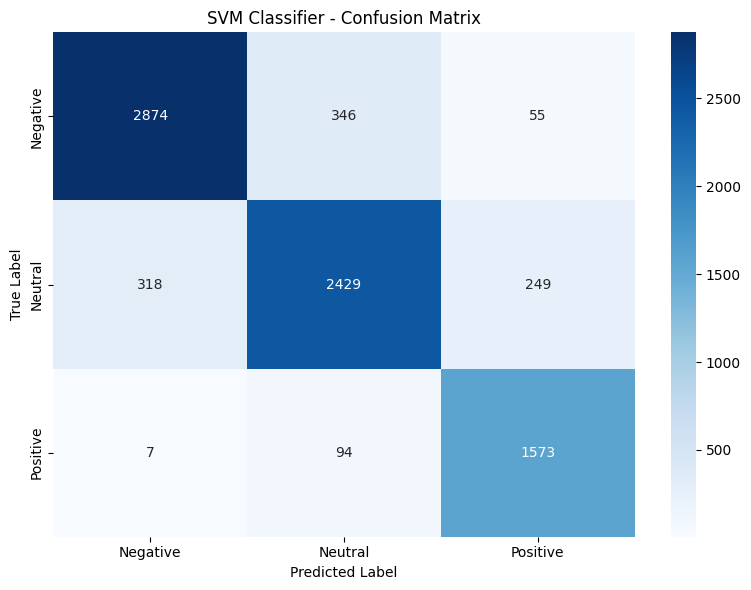


💾 Test predictions saved to 'svm_test_predictions.csv'
Trained SVM model saved as: svm_sentiment_classifier.pkl
Text embeddings saved as: text_embeddings.npy

🧪 Testing SVM prediction function...

Sample Predictions:
Text 1: 'This movie was absolutely fantastic! Brilliant acting and am...'
Prediction: Positive (1)
Confidence: 1.000
Probabilities: Negative: 0.000, Neutral: 0.000, Positive: 1.000
--------------------------------------------------------------------------------
Text 2: 'It was okay, nothing special. Average movie with some good m...'
Prediction: Neutral (0)
Confidence: 0.997
Probabilities: Negative: 0.000, Neutral: 0.997, Positive: 0.003
--------------------------------------------------------------------------------
Text 3: 'Terrible acting and boring story. Complete waste of time....'
Prediction: Negative (-1)
Confidence: 1.000
Probabilities: Negative: 1.000, Neutral: 0.000, Positive: 0.000
--------------------------------------------------------------------------------

C:\Users\Akash\AppData\Local\Temp\ipykernel_21372\1896580946.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  confidence_analysis = test_results.groupby('confidence_bin').agg({


In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

# Load the pre-processed data with sentiment labels
print("Loading movie_reviews_with_sentiment.csv...")
data = pd.read_csv('movie_reviews_with_sentiment.csv')
print(f"Dataset shape: {data.shape}")
print(f"Sentiment distribution:\n{data['sentiment'].value_counts()}")

# Load the embedding model
print("\nLoading all-MiniLM-L6-v2 embedding model...")
embedder = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

# Generate embeddings for the text data
print("Generating sentence embeddings...")
start_time = time.time()

texts = data['text'].fillna('').astype(str).tolist()
embeddings = embedder.encode(texts, show_progress_bar=True, batch_size=32)

print(f"Embeddings generated in {time.time() - start_time:.2f} seconds")
print(f"Embedding shape: {embeddings.shape}")

# Create feature matrix and target variable
X = pd.DataFrame(embeddings)
y = data['sentiment']

# Split data into train and test sets (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")

# Initialize and train SVM classifier
print("\nTraining SVM classifier...")
svm_classifier = SVC(
    kernel='linear', 
    random_state=42, 
    probability=True,  # Enable probability estimates
    class_weight='balanced'  # Handle class imbalance
)

start_time = time.time()
svm_classifier.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"SVM training completed in {training_time:.2f} seconds")

# Make predictions
y_pred = svm_classifier.predict(X_test)
y_pred_proba = svm_classifier.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\n📊 MODEL EVALUATION")
print("=" * 50)
print(f"Accuracy: {accuracy:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Negative (-1)', 'Neutral (0)', 'Positive (1)']))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('SVM Classifier - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('svm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Add predictions and probabilities to the test data
test_results = X_test.copy()
test_results['true_sentiment'] = y_test.values
test_results['predicted_sentiment'] = y_pred
test_results['confidence'] = np.max(y_pred_proba, axis=1)

# Get the original text for the test set
test_indices = X_test.index
test_results['text'] = data.loc[test_indices, 'text'].values

# Save test results with predictions
test_results.to_csv('svm_test_predictions.csv', index=False)
print("\n💾 Test predictions saved to 'svm_test_predictions.csv'")

# Save the trained SVM model
model_filename = 'svm_sentiment_classifier.pkl'
joblib.dump(svm_classifier, model_filename)
print(f"Trained SVM model saved as: {model_filename}")

# Save the embeddings for future use
embeddings_filename = 'text_embeddings.npy'
np.save(embeddings_filename, embeddings)
print(f"Text embeddings saved as: {embeddings_filename}")

# Create a prediction function for new data
def predict_sentiment_svm(new_texts, model=svm_classifier, embedder=embedder):
    """
    Predict sentiment for new texts using the trained SVM model
    
    Args:
        new_texts (list): List of text strings to analyze
        model: Trained SVM classifier
        embedder: Sentence transformer model
        
    Returns:
        tuple: (predictions, probabilities, confidence_scores)
    """
    # Generate embeddings for new texts
    new_embeddings = embedder.encode(new_texts, show_progress_bar=False)
    
    # Predict sentiment labels
    predictions = model.predict(new_embeddings)
    
    # Get prediction probabilities
    probabilities = model.predict_proba(new_embeddings)
    
    # Get confidence scores (max probability)
    confidence_scores = np.max(probabilities, axis=1)
    
    return predictions, probabilities, confidence_scores

# Test the prediction function with sample texts
print("\n🧪 Testing SVM prediction function...")
sample_texts = [
    "This movie was absolutely fantastic! Brilliant acting and amazing storyline.",
    "It was okay, nothing special. Average movie with some good moments.",
    "Terrible acting and boring story. Complete waste of time.",
    "The cinematography was beautiful but the plot was confusing.",
    "One of the best films I've ever seen! Masterpiece!"
]

predictions, probabilities, confidence = predict_sentiment_svm(sample_texts)
sentiment_map = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}

print("\nSample Predictions:")
print("=" * 80)
for i, (text, pred, prob, conf) in enumerate(zip(sample_texts, predictions, probabilities, confidence)):
    pred_label = sentiment_map[pred]
    print(f"Text {i+1}: '{text[:60]}...'")
    print(f"Prediction: {pred_label} ({pred})")
    print(f"Confidence: {conf:.3f}")
    print(f"Probabilities: Negative: {prob[0]:.3f}, Neutral: {prob[1]:.3f}, Positive: {prob[2]:.3f}")
    print("-" * 80)

# Analyze model performance by confidence levels
print("\n📈 Confidence Analysis:")
confidence_bins = [0, 0.6, 0.8, 0.9, 1.0]
confidence_labels = ['Low (0-0.6)', 'Medium (0.6-0.8)', 'High (0.8-0.9)', 'Very High (0.9-1.0)']

test_results['confidence_bin'] = pd.cut(test_results['confidence'], bins=confidence_bins, labels=confidence_labels)

confidence_analysis = test_results.groupby('confidence_bin').agg({
    'true_sentiment': 'count',
    'confidence': 'mean'
}).rename(columns={'true_sentiment': 'count', 'confidence': 'avg_confidence'})

confidence_accuracy = []
for bin_label in confidence_labels:
    bin_data = test_results[test_results['confidence_bin'] == bin_label]
    if len(bin_data) > 0:
        acc = accuracy_score(bin_data['true_sentiment'], bin_data['predicted_sentiment'])
        confidence_accuracy.append(acc)
    else:
        confidence_accuracy.append(0)

confidence_analysis['accuracy'] = confidence_accuracy
print(confidence_analysis)

# Save final model metrics
model_metrics = {
    'accuracy': accuracy,
    'training_time_seconds': training_time,
    'num_features': X_train.shape[1],
    'train_samples': X_train.shape[0],
    'test_samples': X_test.shape[0],
    'model_type': 'SVM with linear kernel'
}

metrics_df = pd.DataFrame([model_metrics])
metrics_df.to_csv('svm_model_metrics.csv', index=False)
print(f"\n💾 Model metrics saved to 'svm_model_metrics.csv'")

print("\n✅ SVM sentiment classification pipeline completed successfully!")
print("🎯 Model is ready for production use!")